# 1. General setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 2. Import data & exploring data

Download the data from a local .csv file, save it in a Pandas DataFrame, take a quick look at the first few line of the training dataset.

In [2]:
df=pd.read_csv('RegressionTrain.csv')
df.head(3)

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,My Happiness,Connie Francis,adult standards,1996,107,31,45,-8,13,28,150,75,3,44
1,2,Unchained Melody,The Teddy Bears,NaN,2011,114,44,53,-8,13,47,139,49,3,37
2,3,How Deep Is Your Love,Bee Gees,adult standards,1979,105,36,63,-9,13,67,245,11,3,77


info() provides us with details about the number of columns in the data frame, size (number of rows), and the type of the data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   top genre  438 non-null    object
 4   year       453 non-null    int64 
 5   bpm        453 non-null    int64 
 6   nrgy       453 non-null    int64 
 7   dnce       453 non-null    int64 
 8   dB         453 non-null    int64 
 9   live       453 non-null    int64 
 10  val        453 non-null    int64 
 11  dur        453 non-null    int64 
 12  acous      453 non-null    int64 
 13  spch       453 non-null    int64 
 14  pop        453 non-null    int64 
dtypes: int64(12), object(3)
memory usage: 53.2+ KB


This dataset contain 15 columns and 453 instances. There are 3 non-numeric attributes, Id column, and 11 numeric attributes.

Due to year has meaning of timeline, so I convert it to age which has quantitative meaning and could be more helpful for regression problem.

In [4]:
from datetime import date
today=date.today()
df['age']=today.year-df['year']
df = df.drop('year', axis=1)
df.head(3)

,Id,title,artist,top genre,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,age
0,1,My Happiness,Connie Francis,adult standards,107,31,45,-8,13,28,150,75,3,44,26
1,2,Unchained Melody,The Teddy Bears,NaN,114,44,53,-8,13,47,139,49,3,37,11
2,3,How Deep Is Your Love,Bee Gees,adult standards,105,36,63,-9,13,67,245,11,3,77,43


Check null values

In [5]:
df.isnull().sum()

Id            0
title         0
artist        0
top genre    15
bpm           0
nrgy          0
dnce          0
dB            0
live          0
val           0
dur           0
acous         0
spch          0
pop           0
age           0
dtype: int64

The only column which contains null values is "top genre".

Next step, I investigate three non-numeric attributes.

In [6]:
df['title'].value_counts()

Take Good Care Of My Baby - 1990 Remastered    2
Please Mr. Postman                             2
Lollipop                                       1
Held for Questioning                           1
Last Christmas                                 1
                                              ..
Freed From Desire                              1
Doin' It                                       1
Don't Stop                                     1
I Have Nothing - Film Version                  1
We Will Rock You - Remastered                  1
Name: title, Length: 451, dtype: int64

In [7]:
artist_count=df['artist'].value_counts()
artist_count

Elton John                 9
ABBA                       7
Queen                      7
The Beatles                6
Whitney Houston            5
                          ..
Craig David                1
Timi Yuro                  1
Ike Carpenter Orchestra    1
Yazoo                      1
John Denver                1
Name: artist, Length: 345, dtype: int64

In [8]:
df['top genre'].value_counts()

adult standards       68
album rock            66
dance pop             61
brill building pop    16
glam rock             16
                      ..
glam punk              1
belgian dance          1
afrobeat               1
italian pop            1
uk garage              1
Name: top genre, Length: 86, dtype: int64

As we can see, there are 86 different categories in 'top genre' column, 345 different artists in the 'artist' column, and 451 titles in the 'title' column. If we use 'OneHotEncoder' to convert these columns to numerical (binary) data, we will have to many columns. On the other hand, the dataframe has only 453 instances. Therefore, in this project, I will not use these three columns for building regression models. As a result, 15 NAN values in 'top genre' column will not cause any issue since this column will be excluded. 

Moreover, there are two titles: "Take Good Care Of My Baby - 1990 Remastered" and "Please Mr. Postman" that are repeated twice in the dataset. I will try to deal with this issue in the prepare data section.  

Plot histogram for numeric attribute to see the distribution of training data.

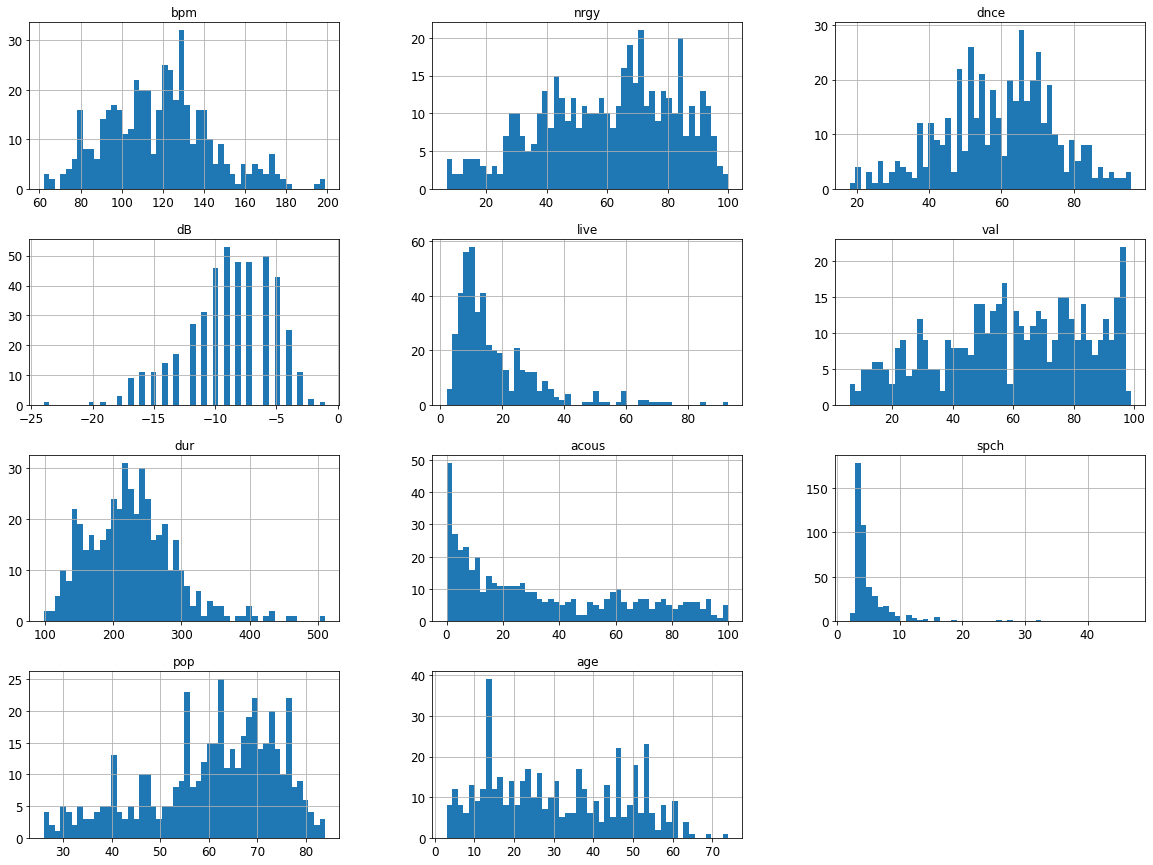

In [9]:
df[['bpm','nrgy','dnce','dB','live','val','dur','acous','spch','pop','age']].hist(bins=50, figsize=(20,15))
plt.show()

# 3. Data visuallisation

Calculate correlation coefficients.

In [10]:
corr_matrix = df.corr()
corr_matrix["pop"].sort_values(ascending=False)

pop      1.000000
dur      0.363266
dB       0.316854
nrgy     0.303797
dnce     0.258670
spch     0.130955
Id       0.086837
bpm      0.055024
age      0.054293
val     -0.018713
live    -0.051364
acous   -0.465875
Name: pop, dtype: float64

Next step, I plot scatter graphs and regression lines for 'pop' versus each individual feature (except feature 'val', since 'val' has very low correletation with 'pop'). In facts, I tried many times for both linear and non-linear assumptions with different degree. These plots below are our best options.

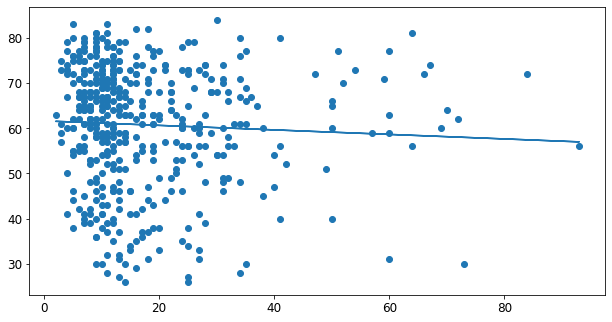

In [11]:
# live & pop
Xplot = df['live']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
z = np.polyfit(Xplot, df['pop'], 1)
p = np.poly1d(z)
ax.scatter(Xplot, df['pop'])
ax.plot(Xplot, p(Xplot))

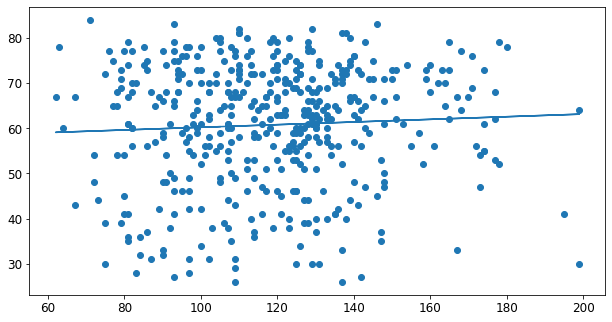

In [12]:
# bpm & pop
Xplot = df['bpm']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
z = np.polyfit(Xplot, df['pop'], 1)
p = np.poly1d(z)
ax.scatter(Xplot, df['pop'])
ax.plot(Xplot, p(Xplot))

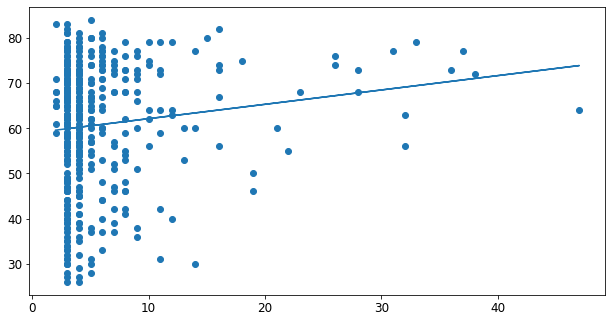

In [13]:
# spch & pop
Xplot = df['spch']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
z = np.polyfit(Xplot, df['pop'], 1)
p = np.poly1d(z)
ax.scatter(Xplot, df['pop'])
ax.plot(Xplot, p(Xplot))

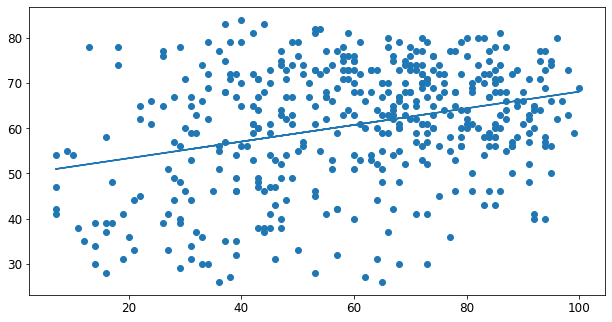

In [14]:
# nrgy & pop
Xplot = df['nrgy']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
z = np.polyfit(Xplot, df['pop'], 1)
p = np.poly1d(z)
ax.scatter(Xplot, df['pop'])
ax.plot(Xplot, p(Xplot))

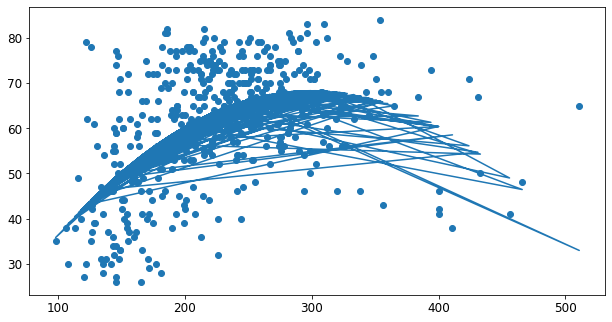

In [15]:
# dur & pop
Xplot = df['dur']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
z = np.polyfit(Xplot, df['pop'], 2)
p = np.poly1d(z)
ax.scatter(Xplot, df['pop'])
ax.plot(Xplot, p(Xplot))

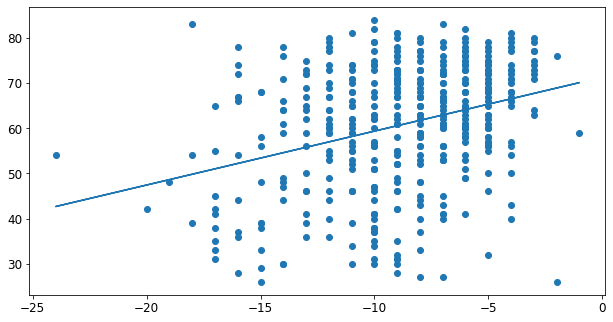

In [16]:
# dB & pop
Xplot = df['dB']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
z = np.polyfit(Xplot, df['pop'], 1)
p = np.poly1d(z)
ax.scatter(Xplot, df['pop'])
ax.plot(Xplot, p(Xplot))

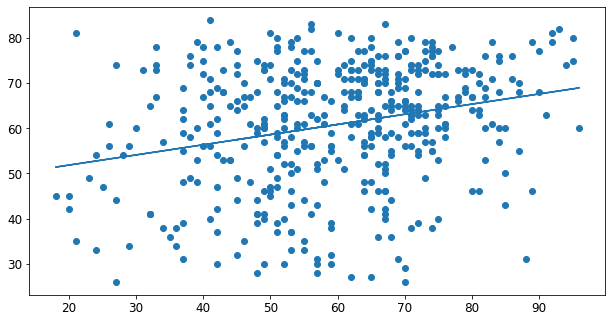

In [17]:
# dnce & pop
Xplot = df['dnce']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
z = np.polyfit(Xplot, df['pop'], 1)
p = np.poly1d(z)
ax.scatter(Xplot, df['pop'])
ax.plot(Xplot, p(Xplot))

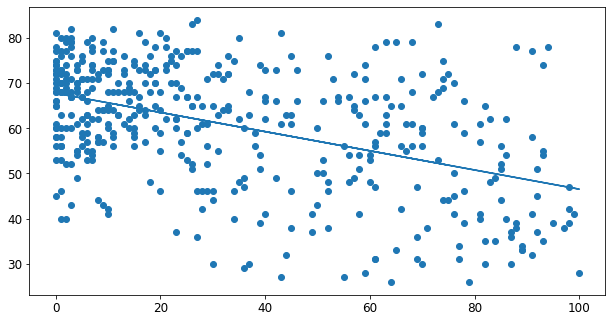

In [18]:
# acous & pop
Xplot = df['acous']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
z = np.polyfit(Xplot, df['pop'], 1)
p = np.poly1d(z)
ax.scatter(Xplot, df['pop'])
ax.plot(Xplot, p(Xplot))

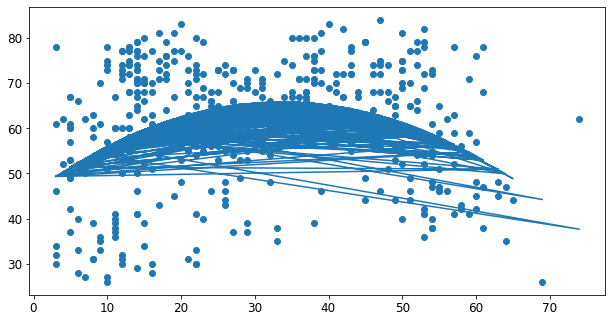

In [19]:
# age & pop
Xplot = df['age']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
z = np.polyfit(Xplot, df['pop'], 2)
p = np.poly1d(z)
ax.scatter(Xplot, df['pop'])
ax.plot(Xplot, p(Xplot))

Base on the correlation coefficients and plots, we can see that "dur" and "age" may have non-linear relationship. The other attribute, including 'acous', 'dur', 'dB', 'nrgy', 'dnce', 'spch' may have the potential linear relationships with "pop".

# 4. Preparing data

# 4.1. Clean data

## a) Clean repeated data
In the part of investigating 'title' column in section 2, we can see two songs repeated, which are 'Take Good Care Of My Baby - 1990 Remastered' and 'Please Mr. Postman'. I extract them for more detail. 

In [20]:
df[df["title"]=='Take Good Care Of My Baby - 1990 Remastered']

,Id,title,artist,top genre,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,age
42,43,Take Good Care Of My Baby - 1990 Remastered,Bobby Vee,adult standards,82,43,49,-12,12,66,151,70,6,60,11
46,47,Take Good Care Of My Baby - 1990 Remastered,Bobby Vee,adult standards,82,43,49,-12,12,66,151,70,6,60,11


In [21]:
df[df["title"]=='Please Mr. Postman']

,Id,title,artist,top genre,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,age
177,178,Please Mr. Postman,Carpenters,adult standards,133,55,66,-12,24,96,173,14,3,62,47
280,281,Please Mr. Postman,The Marvelettes,brill building pop,122,78,79,-5,18,97,148,73,3,68,61


Since the data in rows 42 and 46 are identical, I will remove one of them. On the other hand, except from the song title, all other features in rows 177 and 280 are different. Therefore, we can consider them as two different instances and I will keep both of them.

In [22]:
df = df.drop(42)
df[df["title"]=='Take Good Care Of My Baby - 1990 Remastered']

,Id,title,artist,top genre,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,age
46,47,Take Good Care Of My Baby - 1990 Remastered,Bobby Vee,adult standards,82,43,49,-12,12,66,151,70,6,60,11


### b) Drop un-used columns

The 'Id', 'title', 'artist', 'top genre' columns will not be used. Therefore, they are excluded from the dataset as follows:

In [23]:
df = df.drop(['Id', 'title', 'artist', 'top genre'], axis=1)
df.head(3)

,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,age
0,107,31,45,-8,13,28,150,75,3,44,26
1,114,44,53,-8,13,47,139,49,3,37,11
2,105,36,63,-9,13,67,245,11,3,77,43


### c) Remove outliers manually

Firstly, I plot box plots to observe potential outliers. And then I remove outliers.

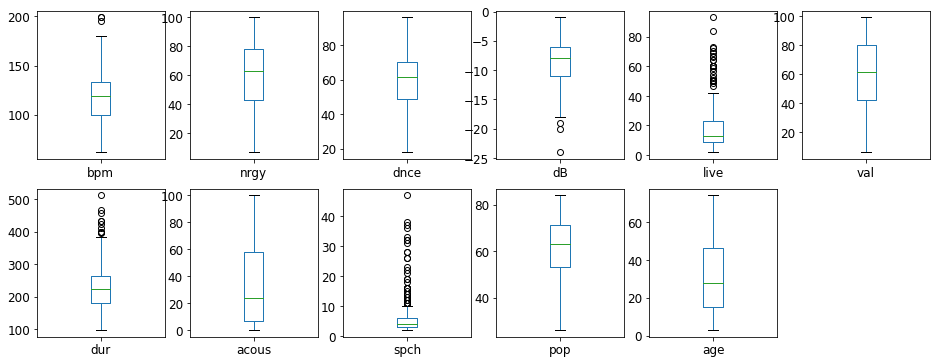

In [24]:
df.plot(kind='box',subplots=True, layout=(2,6), figsize=(16,6))
plt.show()

I remove outliers founded from previous step.

In [25]:
df = df[df['bpm']< 185]
df = df[df['dur']< 380]
df = df[(df['spch']< 11) & (df['spch']>= 2.5)]
df = df[df['dB'] > -18]
df = df[df['live'] < 40]

df.head(3)

,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,age
0,107,31,45,-8,13,28,150,75,3,44,26
1,114,44,53,-8,13,47,139,49,3,37,11
2,105,36,63,-9,13,67,245,11,3,77,43


### d) Remove outliers by using DBSCAN clustering

In addition to removing manually base on the box plot in the previous step, I use clustering technique to detect anormal data points which can be considered as outliers which need to be removed. As we can see in the plots in Section 3, the data distributions are not really spherical. Therefore, DBSCAN clustering is chosen. The value of parameter "eps" in each clustering will be adjusted according to the density of the scatter plots observed in Section 3.

In [26]:
from sklearn.cluster import DBSCAN

## clustering for a sub-dataframe with only two columns: 'pop' and 'acous'
dbscan = DBSCAN(eps=9, min_samples=5)
dbscan.fit(df[['acous', 'pop']])
# dbscan.labels_
df = df.loc[dbscan.labels_!=-1]

## clustering for a sub-dataframe with only two columns: 'pop' and 'dur'
dbscan = DBSCAN(eps=15, min_samples=5)
dbscan.fit(df[['dur', 'pop']])
# dbscan.labels_
df = df.loc[dbscan.labels_!=-1]

## clustering for a sub-dataframe with only two columns: 'pop' and 'nrgy'
dbscan = DBSCAN(eps=10, min_samples=5)
dbscan.fit(df[['nrgy', 'pop']])
# dbscan.labels_
df = df.loc[dbscan.labels_!=-1]

## clustering for a sub-dataframe with only two columns: 'pop' and 'dnce'
dbscan = DBSCAN(eps=10, min_samples=5)
dbscan.fit(df[['dnce', 'pop']])
# dbscan.labels_
df = df.loc[dbscan.labels_!=-1]

## clustering for a sub-dataframe with only two columns: 'pop' and 'age'
dbscan = DBSCAN(eps=10, min_samples=5)
dbscan.fit(df[['age', 'pop']])
# dbscan.labels_
df = df.loc[dbscan.labels_!=-1]


By removing outliers, the coefficients in the correlation matrix below increased compared to those in the correlation matrix before cleaning data.

In [27]:
corr_matrix = df.corr()
corr_matrix["pop"].sort_values(ascending=False)

pop      1.000000
dur      0.527409
nrgy     0.370010
dB       0.337413
dnce     0.300716
spch     0.136127
bpm      0.110435
age      0.103531
val      0.014382
live    -0.151479
acous   -0.505619
Name: pop, dtype: float64

## 4.2. Adding features: age^2 and dur^2

Since the potential quadratic relations between 'pop' versus 'age' and 'dur' are observed in the previous section, two additional columns for age^2 and dur^2 will be added into the dataset as follows:

In [28]:
df['age2']=df['age']**2
df['dur2']=df['dur']**2
df.head(3)

,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,age,age2,dur2
0,107,31,45,-8,13,28,150,75,3,44,26,676,22500
1,114,44,53,-8,13,47,139,49,3,37,11,121,19321
2,105,36,63,-9,13,67,245,11,3,77,43,1849,60025


## 4.3. Feature scaling

Based on the correlation scores shown in Section 3, I decided to exclude 'val' feature from our process of building models. A list of features that will be included in the training process are defined in 'features' variable as below. In fact, this is the best list of features that I found after many trial combinations of features.

In [29]:
features = ['dur', 'dur2', 'nrgy', 'dB', 'dnce', 'spch', 'bpm', 'age','age2', 'live', 'acous']
from sklearn.preprocessing import StandardScaler
autoscaler = StandardScaler()
y = df['pop']

X_train = autoscaler.fit_transform(df[features])

# 5. Training models

Setup

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## AdaBoost
from sklearn.ensemble import AdaBoostRegressor
## Gradient Boosting
# from sklearn.ensemble import GradientBoostingRegressor

## 5.1. Train and Fine-Tune Individual Model

I try four different regression models including: LinearRegression, LinearSVR, DecisionTreeRegressor and RandomForestRegressor. The best model will be determined by using following steps:

 + Step 1: Fine-Tune individual models using GridSearchCV to obtain the best parameters for individual models
    
 + Step 2: Use Ensemble Learning including Soft voting, Ada boosting to improve model scores

 + Step 3: Determine the best (final) model based on RMSE score when predict test set

During training, the cross validation technique with cv=5 is used to split data into 5 folds. The best paramters will be used for training the optimised model. 
 

### 5.1.1. Linear Regression

In [31]:
lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X_train, y,scoring="neg_mean_squared_error", cv=5)
lin_reg_rmse_scores = np.sqrt(-scores)
print(lin_reg_rmse_scores.mean())

lin_reg.fit(X_train, y)
lin_reg.coef_

9.682255255045373


array([ 22.43062154, -17.92502001,  -1.74345284,   3.778827  ,
         1.47750619,   1.14170789,  -0.25003311,   9.71767044,
        -7.27047719,  -0.93430575,  -2.68407807])

### 5.1.2. Fine-Tune Support Vector Regression Model

The tolerance 'tol' of the LinearSVR model is set equal to 10e-5, and a gridsearch for 'loss' parameter is conducted. 

In [32]:
svm_reg = LinearSVR(tol=1e-5)

param_grid = {'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']}

grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(X_train, y)
best_para = grid_search.best_params_

## optimised SVR model:
svm_reg = LinearSVR(tol=1e-5, loss = best_para['loss'])

scores = cross_val_score(svm_reg, X_train, y, scoring="neg_mean_squared_error", cv=5)
svm_reg_rmse_scores = np.sqrt(-scores)
print(svm_reg_rmse_scores.mean())

svm_reg.fit(X_train, y)

9.69917059898428


LinearSVR(loss='squared_epsilon_insensitive', tol=1e-05)

### 5.1.3. Fine-Tune Decision Tree Regression Model

Two parameters: 'max_features' and 'max_depth' are used for the gridsearch.

In [33]:
tree_reg = DecisionTreeRegressor()

param_grid = {'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [2, 4, 6, 8, 10,12,14,16,18,20]}

grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(X_train, y)
best_para = grid_search.best_params_


## optimised DecisionTreeRegressor model:
tree_reg = DecisionTreeRegressor(max_depth=best_para['max_depth'], max_features=best_para['max_features'])

scores = cross_val_score(tree_reg, X_train, y, scoring="neg_mean_squared_error", cv=5)
tree_reg_rmse_scores = np.sqrt(-scores)
print(tree_reg_rmse_scores.mean())

tree_reg.fit(X_train, y)

11.596116655657926


DecisionTreeRegressor(max_depth=2, max_features='sqrt')

### 5.1.4. Fine-Tune Random Forest Model

Three parameters: 'n_estimators', 'max_features' and 'bootstrap' are used for the gridsearch.

Compared to the other regression models, the Random Forest model requires a significantly longer time to train. However, the Random Forest model is generally give very good score, slightly better than the individual models above when make prediction for test set.

In [34]:
forest_reg = RandomForestRegressor()

param_grid = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['auto', 'sqrt', 'log2'], 
              'bootstrap': [True, False]}

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(X_train, y)
best_para = grid_search.best_params_

## Optimised Random Forest model:
forest_reg = RandomForestRegressor(n_estimators=best_para['n_estimators'], bootstrap=best_para['bootstrap'], 
                                   max_features=best_para['max_features'])

scores = cross_val_score(forest_reg, X_train, y,scoring="neg_mean_squared_error", cv=5)
forest_reg_rmse_scores = np.sqrt(-scores)
print(forest_reg_rmse_scores.mean())

forest_reg.fit(X_train, y)

9.683422218095469


RandomForestRegressor(max_features='log2', n_estimators=50)

## 5.2. Ensemble Learning

As the next step, I will use soft voting and Ada boosting methods to improve the models' performances. 

### 5.2.1. Soft voting for the best individual models

By trying different model combinations, I found that soft-voting model of three individual models including 'lin_reg', 'forest_reg' and 'svm_reg' give the higher score than the soft-voting model of all four idividual models. It is because the Decision Tree Regression Model has very low score compared to the others. Therefore, as shown in section below, I only conduct soft voting for three models:

In [35]:
from sklearn.ensemble import VotingRegressor

soft_voting = VotingRegressor(estimators=[('lr', lin_reg), ('forest', forest_reg), ('svm', svm_reg)])

scores = cross_val_score(soft_voting, X_train, y, scoring="neg_mean_squared_error", cv=5)
soft_voting_rmse_scores = np.sqrt(-scores)
print(soft_voting_rmse_scores.mean())

soft_voting.fit(X_train, y)

9.447408980974723


VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('forest',
                             RandomForestRegressor(max_features='log2',
                                                   n_estimators=50)),
                            ('svm',
                             LinearSVR(loss='squared_epsilon_insensitive',
                                       tol=1e-05))])

### 5.2.2. Boosting model

I try to use Ada boosting for the achieved 'soft_voting' model. It is noted that the Ada bossting for each individual model was also tried. However, the performances of those boosting models were not good. On the other hand, sometimes, I did capture slight improvemements when I try Ada boosting for the achieved 'soft_voting' model.

In [36]:
# Ada boosting
from sklearn.ensemble import AdaBoostRegressor

adb_rgr = AdaBoostRegressor(soft_voting, n_estimators=1000, learning_rate=0.5)

scores = cross_val_score(adb_rgr, X_train, y, scoring="neg_mean_squared_error", cv=5)
adb_rgr_rmse_scores = np.sqrt(-scores)
print(adb_rgr_rmse_scores.mean())

adb_rgr.fit(X_train, y)

9.477948955572309


AdaBoostRegressor(base_estimator=VotingRegressor(estimators=[('lr',
                                                              LinearRegression()),
                                                             ('forest',
                                                              RandomForestRegressor(max_features='log2',
                                                                                    n_estimators=50)),
                                                             ('svm',
                                                              LinearSVR(loss='squared_epsilon_insensitive',
                                                                        tol=1e-05))]),
                  learning_rate=0.5, n_estimators=1000)

# 6. Predict test data & choose final model

First, I need to conduct the same operations that I did for trainind data set. These operations include converting year to age, removing 'year', 'title', 'artist', 'top genre' columns, and adding 'age2' and 'dur2' columns as belows:

In [39]:
df_test = pd.read_csv('RegressionTest.csv')

today = date.today()
df_test['age'] = today.year - df_test['year']

df_test = df_test.drop(['year', 'title', 'artist', 'top genre'], axis=1)
df_test['age2'] = df_test['age']**2
df_test['dur2'] = df_test['dur']**2
# df_test.head()

X_test = autoscaler.fit_transform(df_test[features])

Base on the mean values of root mean square errors (obtained using cross validation techique) were printed out. Three models often have best scores on the traning set, including Random Forest, Soft Voting and Ada Boosting, were used to predict test set and then submit for scoring on Kaggle.

The Soft-voting model always gains the best RMSE score for prediction on Kaggle. Therefore, the finally chosen model is Soft-voting !

In this notebook file, I only make prediction for test set using Soft-voting model.

In [41]:
# Load the pickled model
pop1 = soft_voting.predict(X_test)
dfpop1 = df_test.copy()
dfpop1['pop'] = pop1
dfpop1 = dfpop1[['Id', 'pop']]
dfpop1.to_csv('Predict1.csv', index=False)